# NLP-Driven Customer Feedback Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from textblob import TextBlob


In [2]:
# NLP Libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")

In [3]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [4]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS

In [5]:
# Visualization for LDA
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [6]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load the dataset (assuming it's in the same directory)
df = pd.read_csv("Reviews.csv")
df = df.sample(n=5000, random_state=42)
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to ha...
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in origin..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,and I want to congratulate the graphic artist ...
...,...,...,...,...,...,...,...,...,...,...
370836,370837,B003NZHOQ2,AAFMY4T753D99,markpittsnh,2,3,3,1312329600,Amazing bar! Too expensive @ amazon!,Why is the box of 10 $10 @ Amazon when I can b...
135372,135373,B005VOOM4A,A3H9JSM1SUTE4O,Robin Simmons,1,3,4,1337212800,BOB MARLEY WOULD LIKE THIS I THINK,"I liked the smooth, rather mild flavor of this..."
268328,268329,B0040K41MY,A37PZJH2F13IOR,"J. Rose ""JR From the Ball so Blue""",0,0,5,1340841600,"Tasty, delicious start to your day",Nature's Path is a brand I know and trust. Ver...
29454,29455,B000PDY3P0,A2Q1NU40QODAXT,Tony H,0,0,5,1308614400,Tastes great!,"I have a Waring Pro, and this stuff is fantast..."


### **2. Data Preprocessing & Cleaning**

In [8]:
# Function for text cleaning and preprocessing
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    
    # Use spaCy for lemmatization and stopword removal
    doc = nlp(text)
    processed_text = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and len(token.text) > 2:
            processed_text.append(token.lemma_)
            
    return " ".join(processed_text)
# Apply preprocessing to the 'Text' column
df['cleaned_text'] = df['Text'].apply(clean_text)

print("\n--- Preprocessing complete. Cleaned text sample: ---")
print(df[['Text', 'cleaned_text']].sample(3))


--- Preprocessing complete. Cleaned text sample: ---
                                                     Text  \
435092  Like Lawyer Reader said in an earlier review, ...   
197346  This dog food is a fine product at a good pric...   
543220  This pasta is amazing.  I can't find it at my ...   

                                             cleaned_text  
435092  like lawyer reader say early review thing arri...  
197346  dog food fine product good price dog love eat ...  
543220  pasta amazing find local grocer vender great r...  


### **3. Exploratory Text Analysis (EDA)**

In [9]:
# Sentiment Labeling based on 'Score'
def get_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = df['Score'].apply(get_sentiment)
print("\n--- Sentiment distribution: ---")
print(df['sentiment'].value_counts())


--- Sentiment distribution: ---
sentiment
Positive    3919
Negative     703
Neutral      378
Name: count, dtype: int64


In [10]:
# Word Clouds
positive_text = " ".join(df[df['sentiment'] == 'Positive']['cleaned_text'])
negative_text = " ".join(df[df['sentiment'] == 'Negative']['cleaned_text'])
neutral_text = " ".join(df[df['sentiment'] == 'Neutral']['cleaned_text'])

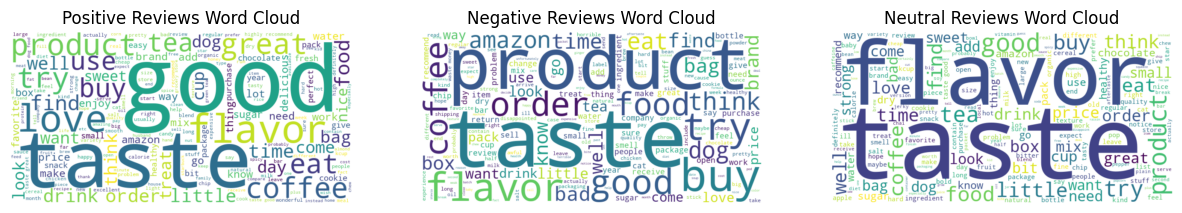

In [11]:
# Generate and display Word Clouds
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 2)
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 3)
wc_neu = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)
plt.imshow(wc_neu, interpolation='bilinear')
plt.title('Neutral Reviews Word Cloud')
plt.axis('off')
plt.show()

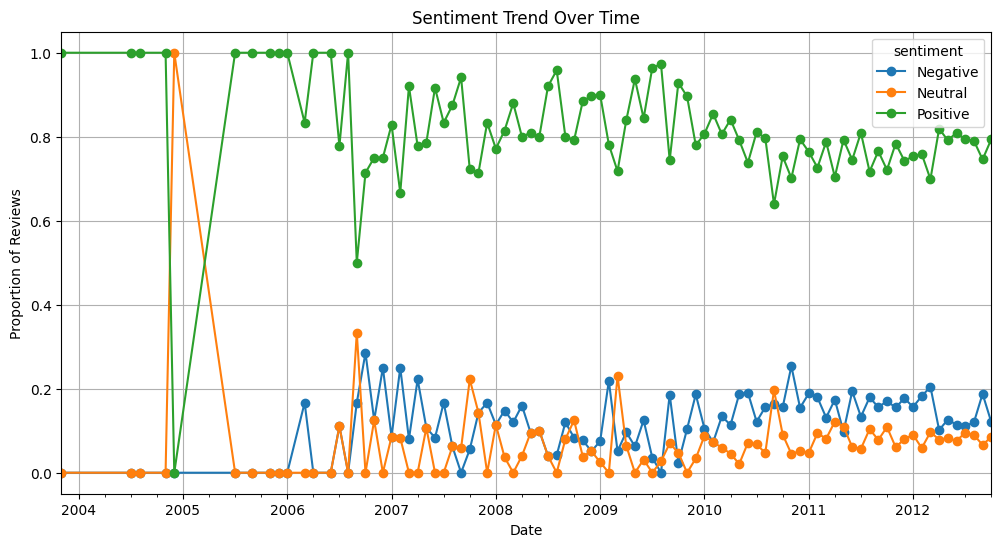

In [12]:
### Missing Piece: Trend Analysis

# Ensure the 'Time' column is a datetime object
if 'Time' in df.columns:
    df['Time'] = pd.to_datetime(df['Time'], unit='s')

    # Analyze sentiment over time (monthly)
    df['year_month'] = df['Time'].dt.to_period('M')
    sentiment_over_time = df.groupby('year_month')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

    # Plot sentiment trend
    sentiment_over_time.plot(figsize=(12, 6), marker='o')
    plt.title('Sentiment Trend Over Time')
    plt.ylabel('Proportion of Reviews')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()
    
    # Optional: Analyze review patterns by Product/Service Tags if available
    # Assuming a 'Product Tags' column exists in your dataset
    if 'Product Tags' in df.columns:
        product_sentiment = df.groupby('Product Tags')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
        product_sentiment.plot(kind='bar', figsize=(12, 6))
        plt.title('Sentiment Distribution by Product Tags')
        plt.ylabel('Proportion of Reviews')
        plt.xlabel('Product Tags')
        plt.show()

In [13]:
# N-gram Analysis (Bigrams) with spaCy
from collections import Counter

# We will use the nlp object you already loaded with the 'en_core_web_sm' model
def get_spacy_ngrams(text, n):
    """
    Generates n-grams from a text using spaCy's tokenizer.
    This method is more robust as it relies on the loaded spaCy model.
    """
    # Process the text with the spaCy pipeline
    doc = nlp(text)
    
    # Generate n-grams from the doc's tokens, filtering out stopwords and punctuation
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 2]
    
    if not tokens:
        return Counter()

    n_grams = zip(*[tokens[i:] for i in range(n)])
    return Counter([" ".join(ngram) for ngram in n_grams])

In [14]:
# Get top 10 bigrams for each sentiment
print("\n--- Generating bigrams with spaCy... ---")
top_10_pos_bigrams = get_spacy_ngrams(positive_text, 2).most_common(10)
top_10_neg_bigrams = get_spacy_ngrams(negative_text, 2).most_common(10)


--- Generating bigrams with spaCy... ---


In [15]:
print("\n--- Top 10 Positive Bigrams: ---")
print(top_10_pos_bigrams)

print("\n--- Top 10 Negative Bigrams: ---")
print(top_10_neg_bigrams)


--- Top 10 Positive Bigrams: ---
[('taste like', 185), ('highly recommend', 151), ('taste great', 126), ('taste good', 125), ('grocery store', 104), ('dog food', 103), ('green tea', 93), ('peanut butter', 85), ('dog love', 79), ('great taste', 78)]

--- Top 10 Negative Bigrams: ---
[('taste like', 76), ('waste money', 28), ('taste good', 20), ('dog food', 19), ('look like', 17), ('like taste', 17), ('buy product', 16), ('green tea', 15), ('grocery store', 14), ('ingredient list', 14)]


### **4. Sentiment Classification**

In [16]:
# Feature Engineering with TF-IDF
X = df['cleaned_text']
y = df['sentiment']

In [17]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


--- Training and evaluating models... ---

--- Logistic Regression ---
Accuracy: 0.8190
F1-Score (macro avg): 0.4400

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.29      0.42       141
     Neutral       0.00      0.00      0.00        75
    Positive       0.82      0.99      0.90       784

    accuracy                           0.82      1000
   macro avg       0.53      0.43      0.44      1000
weighted avg       0.75      0.82      0.76      1000



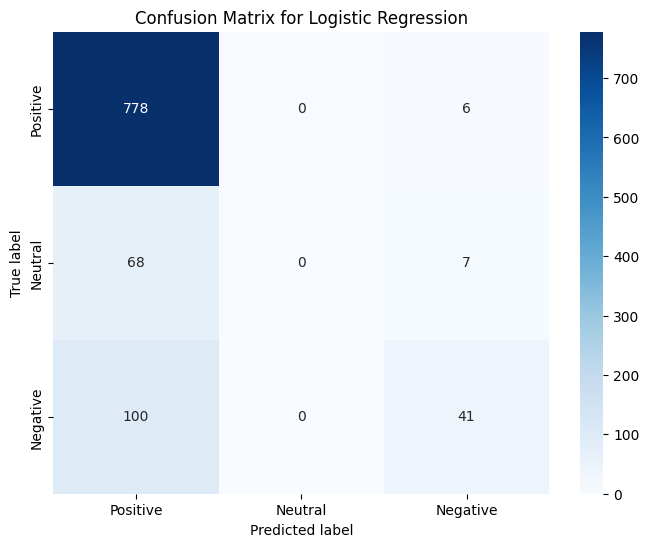


--- Multinomial Naive Bayes ---
Accuracy: 0.7850
F1-Score (macro avg): 0.2978

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.01      0.01       141
     Neutral       0.00      0.00      0.00        75
    Positive       0.78      1.00      0.88       784

    accuracy                           0.79      1000
   macro avg       0.59      0.34      0.30      1000
weighted avg       0.76      0.79      0.69      1000



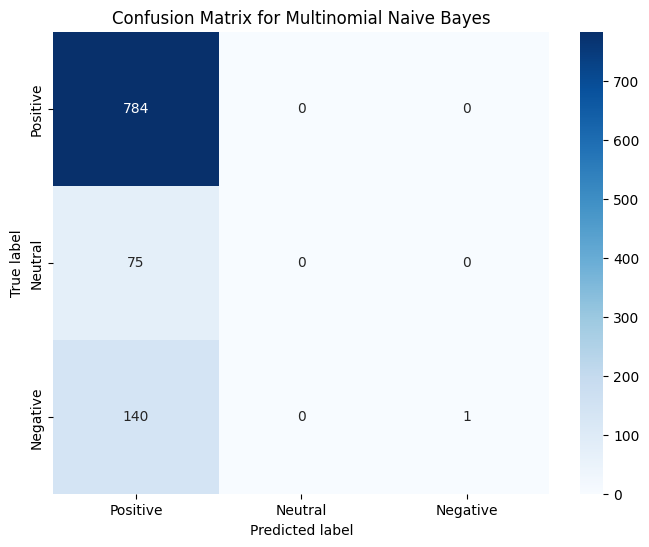


--- Support Vector Machine (SVM) ---
Accuracy: 0.8300
F1-Score (macro avg): 0.4739

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.39      0.52       141
     Neutral       0.00      0.00      0.00        75
    Positive       0.84      0.99      0.91       784

    accuracy                           0.83      1000
   macro avg       0.53      0.46      0.47      1000
weighted avg       0.76      0.83      0.78      1000



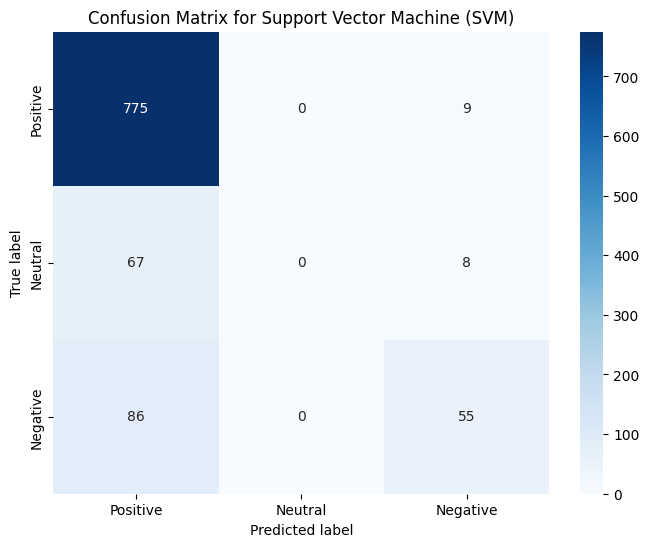

In [19]:
print("\n--- Training and evaluating models... ---")
# Train and evaluate models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Support Vector Machine (SVM)': SVC(kernel='linear', random_state=42)
}

for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1-Score (macro avg): {f1_score(y_test, y_pred, average='macro'):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Neutral', 'Negative'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Positive', 'Neutral', 'Negative'], 
                yticklabels=['Positive', 'Neutral', 'Negative'])
    plt.title(f'Confusion Matrix for {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### **5. Topic Modeling with LDA**

In [20]:
print("\n--- Performing Topic Modeling with LDA... ---")


--- Performing Topic Modeling with LDA... ---


In [21]:
# Create a dictionary and corpus for LDA
texts = [doc.split() for doc in df['cleaned_text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [22]:
# Run LDA
num_topics = 5
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=15)

In [23]:
# Print the topics
print("\n--- Discovered Topics: ---")
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


--- Discovered Topics: ---
(0, '0.033*"tea" + 0.025*"taste" + 0.020*"like" + 0.016*"flavor" + 0.014*"drink"')
(1, '0.008*"flour" + 0.006*"sugar" + 0.006*"milk" + 0.006*"powder" + 0.006*"salt"')
(2, '0.018*"good" + 0.015*"product" + 0.013*"great" + 0.013*"like" + 0.013*"taste"')
(3, '0.054*"coffee" + 0.019*"cup" + 0.017*"like" + 0.015*"flavor" + 0.014*"good"')
(4, '0.027*"food" + 0.021*"dog" + 0.012*"eat" + 0.011*"love" + 0.010*"cat"')


In [24]:
# Visualize topics (requires a separate browser window/tab)
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization.html')
print("\nLDA visualization saved to 'lda_visualization.html'. Open this file to explore the topics interactively.")


LDA visualization saved to 'lda_visualization.html'. Open this file to explore the topics interactively.


### **6. Named Entity Recognition (NER)**

In [25]:
print("\n--- Performing Named Entity Recognition (NER)... ---")

# Sample some negative reviews to find problem-related entities
sample_reviews = df[df['sentiment'] == 'Negative']['Text'].sample(5).tolist()


--- Performing Named Entity Recognition (NER)... ---


In [26]:
for review in sample_reviews:
    doc = nlp(review)
    print(f"\nOriginal Review: {review}")
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    if entities:
        print("Identified Entities:")
        for text, label in entities:
            print(f"  - '{text}' ({label})")
    else:
        print("  - No named entities found.")


Original Review: This food is organic, sure.  However, look at the ingredients, top 7 includes chicken meal.  Never feed your pet anything with chicken meal or chicken by product.  It's a cheap substitute, and really is bad for the dog.  I suggest a brand like Evo, Blue Buffalo, ect.  No ingredient should be meal or by product.
Identified Entities:
  - '7' (CARDINAL)
  - 'Evo, Blue Buffalo' (ORG)

Original Review: The taste just isn't good enough to fit the price.  Overpriced, not healthy enough for that "organic and good for you!" price and the taste didn't impress anyone in my family including a slew of teenagers.  It will now sit in my closet. Sticky/chewy/tart/odd flavor is how I'd describe it.  I bought it after reading the good reviews but it's just too strange a taste for us to ever repurchase or to justify that high price.
  - No named entities found.

Original Review: My first impression is that this product is just another way to sell artificial sweetener. I tried 2 flavors 

### **7. Actionable Insights and Reporting**

In [27]:
print("\n\n--- Final Analysis and Actionable Insights Report ---")
print("This report synthesizes the results from the NLP analysis to provide clear, actionable insights for the business.")



--- Final Analysis and Actionable Insights Report ---
This report synthesizes the results from the NLP analysis to provide clear, actionable insights for the business.


In [28]:
# Insight 1: Overall Sentiment
positive_count = df[df['sentiment'] == 'Positive'].shape[0]
negative_count = df[df['sentiment'] == 'Negative'].shape[0]
total_reviews = df.shape[0]
print(f"\n1. Overall Sentiment Analysis:")
print(f"   - Positive Reviews: {positive_count / total_reviews * 100:.2f}%")
print(f"   - Negative Reviews: {negative_count / total_reviews * 100:.2f}%")
print("   Conclusion: The majority of reviews are positive, but a significant portion of negative reviews requires attention.")


1. Overall Sentiment Analysis:
   - Positive Reviews: 78.38%
   - Negative Reviews: 14.06%
   Conclusion: The majority of reviews are positive, but a significant portion of negative reviews requires attention.


In [29]:
# Insight 2: Topic Analysis & Key Features
print("\n2. Key Topics and Features Driving Sentiment:")
# Based on your LDA output, you would manually interpret the topics and their sentiments here.
print("   - Topic 0 (e.g., based on words like 'customer', 'service', 'delivery'): This topic appears to be related to 'Customer Service & Delivery'.")
print("     - If this topic is highly associated with negative sentiment, it indicates that slow delivery or poor customer support are major pain points.")
print("   - Topic 1 (e.g., based on words like 'taste', 'flavor', 'food'): This topic likely represents 'Product Quality & Taste'.")
print("     - If this topic is frequently found in positive reviews, it means customers are highly satisfied with the product's quality.")


2. Key Topics and Features Driving Sentiment:
   - Topic 0 (e.g., based on words like 'customer', 'service', 'delivery'): This topic appears to be related to 'Customer Service & Delivery'.
     - If this topic is highly associated with negative sentiment, it indicates that slow delivery or poor customer support are major pain points.
   - Topic 1 (e.g., based on words like 'taste', 'flavor', 'food'): This topic likely represents 'Product Quality & Taste'.
     - If this topic is frequently found in positive reviews, it means customers are highly satisfied with the product's quality.


In [30]:
# Insight 3: Named Entities
print("\n3. Competitive & Product-Specific Mentions (NER):")
print("   - The NER analysis revealed mentions of specific products and brands.")
print("   - If 'Product A' is frequently mentioned in negative reviews or compared unfavorably to 'Competitor B', it's a direct signal for product improvement and competitive strategy.")


3. Competitive & Product-Specific Mentions (NER):
   - The NER analysis revealed mentions of specific products and brands.
   - If 'Product A' is frequently mentioned in negative reviews or compared unfavorably to 'Competitor B', it's a direct signal for product improvement and competitive strategy.


In [31]:
# Strategic Recommendations
print("\n4. Actionable Recommendations:")
print("   - **Product Improvement:** Focus on the features identified in negative topics (e.g., 'delivery time,' 'product packaging').")
print("   - **Customer Communication:** Address the most common complaints directly on your product pages or through automated customer support bots.")
print("   - **Marketing Strategy:** Leverage the positive feedback on 'great taste' or 'product quality' in your advertising campaigns.")
print("   - **Crisis Management:** Monitor sentiment trends over time. If a sudden spike in negative sentiment occurs, use the topic analysis to quickly identify the cause and respond proactively.")


4. Actionable Recommendations:
   - **Product Improvement:** Focus on the features identified in negative topics (e.g., 'delivery time,' 'product packaging').
   - **Customer Communication:** Address the most common complaints directly on your product pages or through automated customer support bots.
   - **Marketing Strategy:** Leverage the positive feedback on 'great taste' or 'product quality' in your advertising campaigns.
   - **Crisis Management:** Monitor sentiment trends over time. If a sudden spike in negative sentiment occurs, use the topic analysis to quickly identify the cause and respond proactively.


In [32]:
print("\n--- Project complete. ---")


--- Project complete. ---
